# 01_pre-segment

This script loads Sentinel data for a given location and time window using DEA sandbox. Load all bands and metadata neccesary for estimating indices

All runs should be initited with a unique identifier 'stub' that carries through to the outputs

Then:
1. Calculates fourier transform 3-band image for input to segment anything
2. Calculate band indices as additional variables in the xarray ds?
3. Saves the xarray ds as netCDF to be reloaded later on. 

Acks: D.Roberts' code for Fourier Transform, DEA scripts for vegetation phenology

In [1]:
#import hdstats
import joblib

%matplotlib inline

import os
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray  # activate the rio accessor

import datetime as dt
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.temporal import xr_phenology, temporal_statistics
from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.plotting import display_map, rgb
from dea_tools.dask import create_local_dask_cluster

import hdstats

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/john.burley@anu.edu.au/proxy/8787/status,
Dashboard: /user/john.burley@anu.edu.au/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34585,Workers: 1
Dashboard: /user/john.burley@anu.edu.au/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:41035,Total threads: 2
Dashboard: /user/john.burley@anu.edu.au/proxy/36569/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:46211,


In [3]:
## Connect to datacube

dc = datacube.Datacube(app='Vegetation_phenology')

In [24]:

os.chdir('/home/jovyan/Projects/PaddockTS')

# set output vars
stub = 'GRANT'
out_path = 'Data/'


In [35]:
# Define area of interest

# # 186 Milgadara Rd, Barwang NSW: -34.38904277303204, 148.46949938279096
# Yelkin -33.47904684379098, 146.3094839864518
# Boomahnoomoona -36.11965805095775, 146.08472404116773
# Adam O'tool site: -33.5040228817206, 148.6385170105664
# Grant Sims multispecies cover crop experiment sites -36.22746736927963, 144.40088864017818
lat = -36.22746736927963
lon = 144.40088864017818
lon_buffer = 0.01
lat_buffer = 0.01


# Set the range of dates for the analysis
time_range = ('2019-01-01', '2020-01-01') # when is the earliest? 2016?

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)

display_map(x=lon_range, y=lat_range)


In [48]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_nir_1', 'nbart_red_edge_1', 'nbart_swir_2'],
    'resolution': (-20, 20),
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}

# Load available data from Sentinel-2
ds = load_ard(
    dc=dc,
    products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
    cloud_mask='s2cloudless',
    min_gooddata=0.9,
    **query,
)

# Shut down Dask client now that we have loaded the data we need
client.close()

# Preview data
ds


Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using s2cloudless
Filtering to 52 out of 74 time steps with at least 90.0% good quality pixels
Applying s2cloudless pixel quality/cloud mask
Loading 52 time steps


<xarray.Dataset>
Dimensions:           (time: 52, y: 104, x: 98)
Coordinates:
  * time              (time) datetime64[ns] 2019-01-01T00:27:00.824000 ... 20...
  * y                 (y) float64 -4.326e+06 -4.326e+06 ... -4.328e+06
  * x                 (x) float64 1.393e+07 1.393e+07 ... 1.393e+07 1.393e+07
    spatial_ref       int32 6933
Data variables:
    nbart_red         (time, y, x) float32 1.588e+03 1.548e+03 ... 2.522e+03
    nbart_green       (time, y, x) float32 1.136e+03 1.14e+03 ... 1.772e+03
    nbart_blue        (time, y, x) float32 796.0 816.0 ... 1.244e+03 1.206e+03
    nbart_nir_1       (time, y, x) float32 2.29e+03 2.295e+03 ... 3.395e+03
    nbart_red_edge_1  (time, y, x) float32 1.76e+03 1.76e+03 ... 2.845e+03
    nbart_swir_2      (time, y, x) float32 4.003e+03 4.003e+03 ... 4.189e+03
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [45]:
# # check out different measurement names:
# dc.list_products().to_csv("dc.list_products.tsv", sep = "\t")
# dc.list_measurements().to_csv("dc.list_measurements.tsv", sep = "\t")

### Create band indices and save the xarray object

#TO DO

In [53]:
ds_ind = calculate_indices(ds, 
                           index=['NDVI',
                                  'NDWI',
                                  'LAI',
                                  'SAVI'], 
                           collection='ga_s2_3')
ds_ind

<xarray.Dataset>
Dimensions:           (time: 52, y: 104, x: 98)
Coordinates:
  * time              (time) datetime64[ns] 2019-01-01T00:27:00.824000 ... 20...
  * y                 (y) float64 -4.326e+06 -4.326e+06 ... -4.328e+06
  * x                 (x) float64 1.393e+07 1.393e+07 ... 1.393e+07 1.393e+07
    spatial_ref       int32 6933
Data variables:
    nbart_red         (time, y, x) float32 1.588e+03 1.548e+03 ... 2.522e+03
    nbart_green       (time, y, x) float32 1.136e+03 1.14e+03 ... 1.772e+03
    nbart_blue        (time, y, x) float32 796.0 816.0 ... 1.244e+03 1.206e+03
    nbart_nir_1       (time, y, x) float32 2.29e+03 2.295e+03 ... 3.395e+03
    nbart_red_edge_1  (time, y, x) float32 1.76e+03 1.76e+03 ... 2.845e+03
    nbart_swir_2      (time, y, x) float32 4.003e+03 4.003e+03 ... 4.189e+03
    NDVI              (time, y, x) float32 0.181 0.1944 0.1806 ... 0.1371 0.1475
    NDWI              (time, y, x) float32 -0.3368 -0.3362 ... -0.3065 -0.3141
    LAI               (time, y, x) float32 0.2827 0.319 0.291 ... 0.2615 0.2873
    SAVI              (time, y, x) float32 0.1186 0.1267 0.1218 ... 0.1122 0.12
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [ ]:
# Also add: dNDVI, NDYI, CAI, faPAR

In [33]:
# make a copy of the ds next time!!
ds_ = ds_ind

ds_.time.attrs.pop('units', None)
ds_.to_netcdf(out_path+stub+'_ds.nc')



### Get NDWI (and NDVI) time series and and calculate Fourier Transform image for input to SAMGeo


In [8]:
data = ds[list(ds.data_vars)].to_array().transpose('y', 'x','variable', 'time').values.astype(np.float32)
data[data == 0] = np.nan
data /= 10000.

dayofyear = np.array(ds.time.dt.dayofyear)
ts = dayofyear/365.

print(data.shape)

(518, 483, 4, 124)


In [9]:
# calculate ndvi first using the missing and non missing data
obs_ndvi = (data[:,:,3,:]-data[:,:,0,:])/(data[:,:,3,:]+data[:,:,0,:])


In [10]:
print('number of missing pixels to be dealt with:', np.count_nonzero(np.isnan(data)))
data = hdstats.completion(data, s=2)


number of missing pixels to be dealt with: 687380


In [11]:
np.count_nonzero(np.isnan(data))


0

In [12]:
# calculate indices from the 'completed' data

ndvi = (data[:,:,3,:]-data[:,:,0,:])/(data[:,:,3,:]+data[:,:,0,:])
ndwi = (data[:,:,1,:]-data[:,:,3,:])/(data[:,:,1,:]+data[:,:,3,:]) # w = water. (g-nir)/(g+nir)



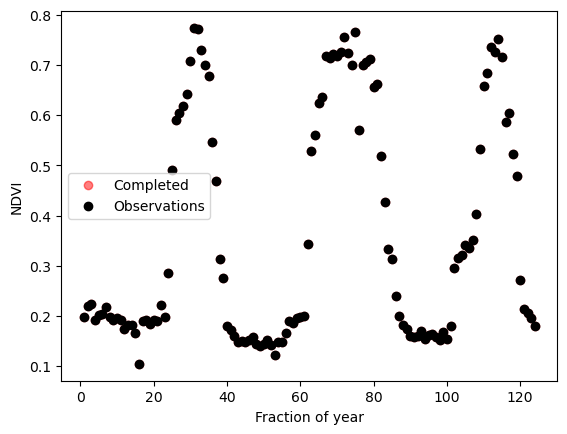

In [13]:
yloc, xloc = data.shape[0]//4, data.shape[1]//4

# specify a time vector
ts = dayofyear/365. # ts x-axis as day of year
# OR
ts = np.array(range(1,data.shape[3]+1)) # ts x-axis as sequential obs days.  

plt.plot(ts, ndvi[yloc,xloc,:], 'ro', alpha=0.5, label='Completed')
plt.plot(ts, obs_ndvi[yloc,xloc,:], 'ko', label='Observations')
plt.xlabel('Fraction of year')
plt.ylabel('NDVI')
plt.legend();

In [15]:
def imshow(data, fs=6, pc=2):
    img = data.copy()
    plt.figure(figsize=(fs,fs*(img.shape[0]/img.shape[1])))

    if len(img.shape) == 3:
        for i in range(min(3, img.shape[2])):
            dd=img[:,:,i]
            pl, pu = np.percentile(dd[np.isfinite(dd)], (pc,100-pc))
            dd[dd<pl], dd[dd>pu] = pl, pu
            dd -= pl
            dd /= (pu - pl)
        plt.imshow(img, aspect='auto')
    else:
        pl, pu = np.percentile(img[np.isfinite(img)], (pc,100-pc))
        plt.imshow(img, aspect='auto', vmin=pl, vmax=pu)
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    plt.tight_layout()

(518, 483, 3)


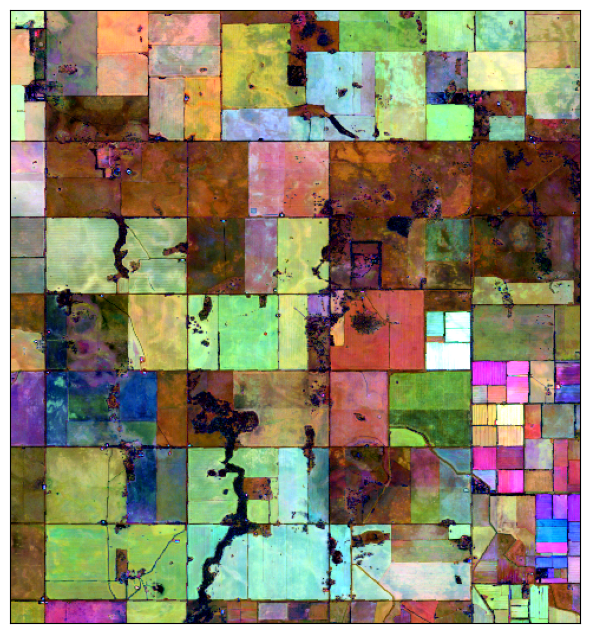

In [17]:
f2 = hdstats.fourier_mean(ndwi)
imshow(f2)
print(f2.shape)

# this is the one

### Rescale the image and save it for SAMgeo

In [26]:
# rescale each band of a numpy array so that it's between 0 and 255

def rescale(im):
    
    '''rescale raster (im) to between 0 and 255.
    Attempts to rescale each band separately, then join them back together to achieve exact same shape as input.
    Note. Assumes multiple bands, otherwise breaks'''
    
    n_bands = im.shape[2]
    #print(n_bands)

    #print(im.shape)

    _im = np.empty(im.shape)

    #print(_im)
    for n in range(0,n_bands):

        #print(n)

        matrix = im[:,:,n]
        scaled_matrix = (255*(matrix - np.min(matrix))/np.ptp(matrix)).astype(int)

        #_im = np.append(_im, scaled_matrix, axis = 0)
        _im[:,:,n] = scaled_matrix

    print('output shape equals input:', im.shape == im.shape)

    imshow(_im)
    
    return(_im)

#t = rescale(drimg[:,:,:3])

In [29]:
def export_for_segmentation(ds, inp, out_stub):
    
    '''prepares a 3-band image for SAMgeo. 
    First rescale bands in the image. Then convert to xarray with original geo info. Then save geotif'''
    
    if inp.shape[2] == 3:
    
        image = rescale(inp) # 3d array 
        lat = list(ds.y.values) # latitude is the same size as the first axis
        lon = list(ds.x.values) # longitude is the same size as second axis
        bands = list(range(1,image.shape[2]+1)) # band is the 3rd axis
        crs = ds.rio.crs
                
        # create xarray object
        data_xr = xr.DataArray(image, 
                       coords={'y': lat,'x': lon,'band': bands}, 
                       dims=["y", "x", "band"])

        data_xr.rio.write_crs(crs, inplace=True)
        
        # save as geotif:
        data_xr.transpose('band', 'y', 'x').rio.to_raster(out_stub + '.tif')
        print('saving to:', out_stub + '.tif')

    else:
        print("Input image is wrong shape! No action taken")
        
    #return(image, data_xr)



output shape equals input: True
saving to: Data/GRANT.tif


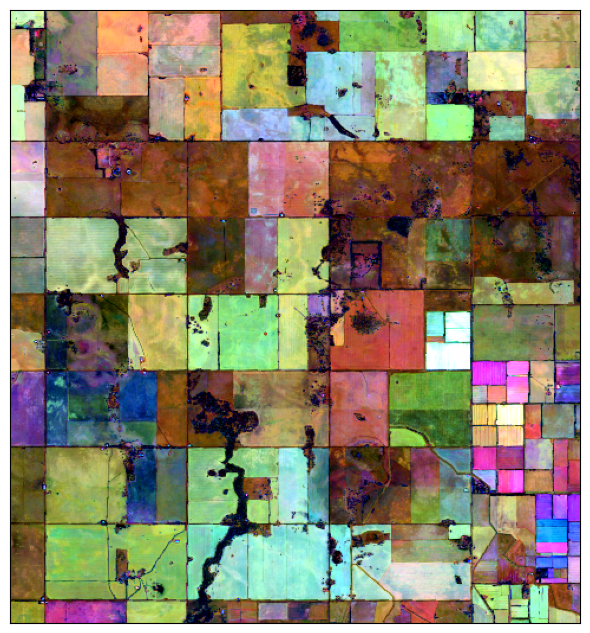

In [30]:
### outpath and stub defined up top. 

export_for_segmentation(ds, f2, out_path+stub)

In [ ]:
### Next importand step in outputs:

In [31]:
image

NameError: name 'image' is not defined

### Next step. (AFTER RUNNING SAMGEO) Time series summary and extraction at paddock level
1. Load polygons generated by segment anything 
2. extract spectral time series summaries for each polyon
3. Save crucial files for next  script



In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np

out_path

In [ ]:
#data_dir = 'Data/Paddocks/'

stub = 'MILG_small'
stub = 'fm_ndwi_4'
stub = 'ADAMO'
stub = 'GRANT'

pol = gpd.read_file(out_path+stub+'_filt.gpkg')

pol['paddock'] = range(1,len(pol)+1)
pol['paddock'] = pol.paddock.astype('category')

pol.plot(column = 'paddock')

In [ ]:
gdf = pol
gdf.explore(column='paddock') # note, I think column must be categorical for this... 

In [ ]:
# add some indices to the data
ds_indi = calculate_indices(ds, index=['NDVI','NDWI'], collection='ga_s2_3') # calculate indices using the DEA tool. # calculate indices using the DEA tool.

ds_indi


In [ ]:
# Loop through every polygon and extract the smoothed time series for some number of bands. 

ts = []

for datarow in pol.itertuples(index=True):
    
    #print(datarow)
    
    ds_clipped = ds_indi.rio.clip([datarow.geometry])
    
    pol_ts = ds_clipped.where(ds_clipped > 0).median(dim = ['x','y'])
    
    array = pol_ts.to_array().transpose('variable', 'time').values.astype(np.float32)
    
    ts.append(array[None,:] )
        
pvt = np.vstack(ts)

In [ ]:
# the result is an array of paddocks by variable (e.g. band) by time
# use ds.time and ds.geometry to bring in the time axis in proper format and location for each paddock
print(pvt.shape)
print(len(pol.geometry), len(ds.time))

np.save(out_path+stub+'_pvt', pvt, allow_pickle=True, fix_imports=True)


In [ ]:
import seaborn as sns

pvt_ndvi = pvt[:,4,:]

sns.heatmap(pvt_ndvi)

In [ ]:
ds.assign_coords

In [ ]:

# # NO LONGER NEEDED?


# # save the time axis of the ds array as a csv so it can be opened as a pd.series

# pd.Series(ds.time.values).to_csv('Data/'+stub+'_ds-time.csv',
#                                 header = False,
#                                 mode = 'w',
#                                 index_label = 'False')


In [ ]:
# make a copy of the ds next time!!
ds_ = ds

ds_.time.attrs.pop('units', None)
ds_.to_netcdf(out_path+stub+'_ds.nc')



In [ ]:
ds_

In [ ]:
ds